In [31]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import keras
from keras.models import Model
from keras.models import Sequential
from keras.layers import Input, Reshape
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling1D, Conv1D
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, SGD
from keras.callbacks import TensorBoard

In [32]:
data = pd.read_csv("/Users/kiem/Developer/data/creditcard.csv")

Let's randomize the data, just to be sure not to get any pathological ordering effects that might harm the performane of Stochastic Gradient Descent.

In [33]:
data = data.reindex(np.random.permutation(data.index))
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
188452,127982.0,-6.510015,5.959764,-5.007941,-2.492069,-0.776336,-1.358914,-0.043818,1.711290,3.191805,...,-0.288667,0.277775,0.120824,-1.154408,1.050129,0.251661,2.277098,1.449942,7.70,0
274176,165884.0,-2.430772,2.851159,-1.765849,-0.836548,0.978243,0.262514,-0.206307,-4.171045,0.914315,...,3.881873,-0.411144,0.165745,-0.071293,0.019454,-0.094698,1.017410,0.622956,46.83,0
83378,59817.0,1.499571,-0.907472,-0.083925,-1.389335,-1.269404,-1.177310,-0.612628,-0.230784,-2.311811,...,-0.118564,-0.029584,-0.057346,0.504676,0.587337,-0.109641,-0.013767,-0.003628,15.00,0
141053,84098.0,1.256235,0.347563,0.301851,0.693207,-0.376918,-1.072151,0.081165,-0.198737,0.045670,...,-0.288815,-0.837949,0.129536,0.337504,0.213873,0.095010,-0.023671,0.030620,1.98,0
30291,35857.0,1.141288,0.125237,0.256195,1.039426,-0.354708,-0.660598,0.070440,-0.022250,-0.089143,...,0.083132,0.119035,-0.123593,0.308753,0.603763,-0.344765,-0.004149,0.012799,35.09,0


In [34]:
data.ndim

2

### Data Wrangling

In [35]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.190191e-15,3.443197e-16,-1.465298e-15,2.102945e-15,9.917299e-16,1.521031e-15,-5.636980e-16,1.191960e-16,-2.414171e-15,...,1.327125e-16,-3.514530e-16,2.580623e-16,4.473883e-15,5.144878e-16,1.698022e-15,-3.760131e-16,-1.132615e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [36]:
data.isnull().sum().sum()

0

Text(0,0.5,'Frequency')

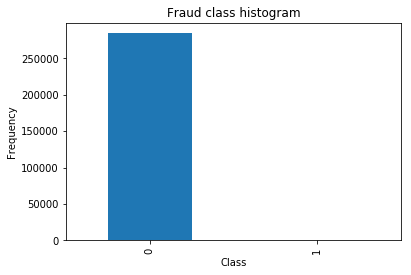

In [37]:
classes = pd.value_counts(data['Class'], sort = True).sort_index()
classes.plot(kind = 'bar')
plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")

In [38]:
data.groupby('Class')['Class'].count()

Class
0    284315
1       492
Name: Class, dtype: int64

#### The Data is hihgly imbalance. 284315 Normal transaction vs 492 Fraud transaction

### Define Features and Configure Feature Columns

In [39]:
data.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [40]:
X = data.iloc[:, 1:30].values
y = data.iloc[:, 30].values

In [41]:
X

array([[ -6.51001485e+00,   5.95976432e+00,  -5.00794065e+00, ...,
          2.27709775e+00,   1.44994235e+00,   7.70000000e+00],
       [ -2.43077161e+00,   2.85115892e+00,  -1.76584885e+00, ...,
          1.01741022e+00,   6.22955537e-01,   4.68300000e+01],
       [  1.49957057e+00,  -9.07471954e-01,  -8.39251188e-02, ...,
         -1.37666383e-02,  -3.62779694e-03,   1.50000000e+01],
       ..., 
       [ -4.23809192e+00,   4.15562430e+00,  -2.46927231e-01, ...,
         -7.15270848e-01,  -7.46243731e-01,   1.00000000e+00],
       [ -5.80684633e-01,  -2.68608440e-01,   1.38598219e+00, ...,
         -7.06099979e-02,  -8.97158940e-02,   2.51590000e+02],
       [  1.84563648e+00,  -7.07232644e-01,   6.39684664e-01, ...,
          1.11341309e-01,  -3.39584941e-02,   3.75000000e+00]])

In [42]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)
print(X_train.shape)

(227845, 29)


### Build a Model

In [43]:
# Initialising the ANN
classifier = Sequential()

In [44]:
# Adding the Input layer and the first hidden layer
classifier.add(Dense(units = 6, activation = 'relu', kernel_initializer = 'uniform', input_dim = 29))

# Adding the second hidden layer
classifier.add(Dense(units = 6, activation = 'relu', kernel_initializer = 'uniform'))

# Adding the output layer
classifier.add(Dense(units = 1, activation = 'sigmoid', kernel_initializer = 'uniform'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Fitting the ANN to the training set
classifier.fit(X_train, y_train, batch_size = 100, epochs = 5)

Epoch 1/5
227845/227845 [==============================] - 3s 14us/step - loss: 0.0587 - acc: 0.9975: 4s - loss: 0.3016 - acc: 0.9 - ETA: 3s - loss: 0.229 - ETA: 1s
Epoch 2/5
227845/227845 [==============================] - 3s 12us/step - loss: 0.0081 - acc: 0.9991
Epoch 3/5
227845/227845 [==============================] - 3s 12us/step - loss: 0.0050 - acc: 0.9993
Epoch 4/5
227845/227845 [==============================] - 3s 12us/step - loss: 0.0045 - acc: 0.9993
Epoch 5/5
227845/227845 [==============================] - 3s 12us/step - loss: 0.0045 - acc: 0.9993: 2s - l - ETA: 1s - loss: 0.0046  - ETA: 0s - loss: 0.0046 - ac


### Make prediction and evaluating the model

In [45]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)
# Convert to T or F boolean value
y_pred = (y_pred > 0.5)

In [46]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[56855,     7],
       [   25,    75]])

### XGBoost

In [47]:
# Fitting XGBoost to the Training set
from xgboost import XGBClassifier
classifier = XGBClassifier()
classifier.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

### Make prediction and evaluating the model

In [48]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)

In [49]:
# Making a Confision Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[56859,     3],
       [   27,    73]])

In [50]:
# Applying k-Fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X=X_train, y=y_train, cv=10)
print(accuracies.mean())
print(accuracies.std())

0.999530381052
0.000140244166454


### Generative Adversarial Networks (GANs)

In [51]:
data = pd.read_csv("/Users/kiem/Developer/data/creditcard.csv")
data.drop(['Time'], axis = 1, inplace = True)
data.drop(['Class'], axis = 1, inplace = True)

In [52]:
# Convert data frame to a numpy array
data = np.array(data)
data

array([[ -1.35980713e+00,  -7.27811733e-02,   2.53634674e+00, ...,
          1.33558377e-01,  -2.10530535e-02,   1.49620000e+02],
       [  1.19185711e+00,   2.66150712e-01,   1.66480113e-01, ...,
         -8.98309914e-03,   1.47241692e-02,   2.69000000e+00],
       [ -1.35835406e+00,  -1.34016307e+00,   1.77320934e+00, ...,
         -5.53527940e-02,  -5.97518406e-02,   3.78660000e+02],
       ..., 
       [  1.91956501e+00,  -3.01253846e-01,  -3.24963981e+00, ...,
          4.45477214e-03,  -2.65608286e-02,   6.78800000e+01],
       [ -2.40440050e-01,   5.30482513e-01,   7.02510230e-01, ...,
          1.08820735e-01,   1.04532821e-01,   1.00000000e+01],
       [ -5.33412522e-01,  -1.89733337e-01,   7.03337367e-01, ...,
         -2.41530880e-03,   1.36489143e-02,   2.17000000e+02]])

In [53]:
# Convert array to PyTorch tensor
data = torch.FloatTensor(data)
data.size()

torch.Size([284807, 29])

In [54]:
# Generator's paragrams
g_input_size = 1     # Random noise dimension coming into generator, per output vector
g_hidden_size = 50   # Generator complexity
g_output_size = 1    # size of generated output vector
g_learning_rate = 2e-4
g_steps = 1

#Discriminator's paragrams
d_input_size = 29   # Minibatch size - cardinality of distributions
d_hidden_size = 50   # Discriminator complexity
d_output_size = 1    # Single dimension for 'real' vs. 'fake'
d_learning_rate = 2e-4
d_steps = 1 

minibatch_size = d_input_size

optim_betas = (0.9, 0.999)
num_epochs = 10000
print_interval = 100

In [55]:
(name, preprocess, d_input_func) = ("Raw data", lambda data: data, lambda x: x)
print("Using data [%s]" % (name))

Using data [Raw data]


In [56]:
def inject_fake_data():
    return lambda m, n: torch.rand(m, n)  # Uniform-dist data into generator, _NOT_ Gaussian


In [57]:
# Generator
class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Generator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.elu(self.map1(x))
        x = F.sigmoid(self.map2(x))
        return self.map3(x)

In [58]:
# Discriminator
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Discriminator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.elu(self.map1(x))
        x = F.elu(self.map2(x))
        return F.sigmoid(self.map3(x))

In [59]:
def extract(v):
    return v.data.storage().tolist()

In [60]:
def stats(d):
    return [np.mean(d), np.std(d)]

In [61]:
def decorate_with_diffs(data, exponent):
    mean = torch.mean(data.data, 1, keepdim=True)
    mean_broadcast = torch.mul(torch.ones(data.size()), mean.tolist()[0][0])
    diffs = torch.pow(data - Variable(mean_broadcast), exponent)
    return torch.cat([data, diffs], 1)

In [62]:
d_sampler = data[0]
gi_sampler = inject_fake_data()
G = Generator(input_size=g_input_size, hidden_size=g_hidden_size, output_size=g_output_size)
D = Discriminator(input_size=d_input_func(d_input_size), hidden_size=d_hidden_size, output_size=d_output_size)

criterion = nn.BCELoss()  # Binary cross entropy: http://pytorch.org/docs/nn.html#bceloss

d_optimizer = optim.Adam(D.parameters(), lr=d_learning_rate, betas=optim_betas)
g_optimizer = optim.Adam(G.parameters(), lr=g_learning_rate, betas=optim_betas)

In [ ]:
# Training loop alternates between two modes
for epoch in range(num_epochs):
    for d_index in range(d_steps):
        # 1. Train Discriminator on real+fake
        D.zero_grad()

        #  1A: Train Discriminator on real data
        d_real_data = Variable(d_sampler)
        d_real_decision = D(preprocess(d_real_data))
        d_real_error = criterion(d_real_decision, Variable(torch.ones(1)))  # ones = true
        d_real_error.backward() # compute/store gradients, but don't change params

        #  1B: Train Discriminator on fake data
        #d_gen_input = Variable(gi_sampler(minibatch_size, 29))
        d_gen_input = Variable(gi_sampler(minibatch_size, g_input_size))
        d_fake_data = G(d_gen_input).detach()  # detach to avoid training G on these labels
        d_fake_decision = D(preprocess(d_fake_data.t()))
        d_fake_error = criterion(d_fake_decision, Variable(torch.zeros(1)))  # zeros = fake
        d_fake_error.backward()
        d_optimizer.step()     # Only optimizes D's parameters; changes based on stored gradients from backward()
        
    for g_index in range(g_steps):
        # 2. Train Generator on Discriminator's response (but DO NOT train D on these labels)
        G.zero_grad()

        gen_input = Variable(gi_sampler(minibatch_size, g_input_size))
        g_fake_data = G(gen_input)
        dg_fake_decision = D(preprocess(g_fake_data.t()))
        g_error = criterion(dg_fake_decision, Variable(torch.ones(1)))  # we want to fool, so pretend it's all genuine

        g_error.backward()
        g_optimizer.step()  # Only optimizes G's parameters
        
    if epoch % print_interval == 0:
        print("%s: Discriminator: Real Error %s / Fake Error %s Generator: %s (Real Data: %s, Fake Data: %s) " % (epoch,
                                                            extract(d_real_error)[0],
                                                            extract(d_fake_error)[0],
                                                            extract(g_error)[0],
                                                            stats(extract(d_real_data)),
                                                            stats(extract(d_fake_data))))



/Users/kiem/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1474: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


0: Discriminator: Real Error 2.9457552433013916 / Fake Error 0.6996848583221436 Generator: 0.6844757199287415 (Real Data: [3.0465385945408836, 49.174943056117513], Fake Data: [0.092201176131593773, 0.0074959623264945685]) 
100: Discriminator: Real Error 0.011755388230085373 / Fake Error 0.5344743728637695 Generator: 0.8903833031654358 (Real Data: [3.0465385945408836, 49.174943056117513], Fake Data: [0.42884511988738488, 0.021184567218151769]) 
200: Discriminator: Real Error 0.0028165271505713463 / Fake Error 0.34491613507270813 Generator: 1.2443408966064453 (Real Data: [3.0465385945408836, 49.174943056117513], Fake Data: [-0.65354267687633116, 0.006623754946964747]) 
300: Discriminator: Real Error 0.002074842806905508 / Fake Error 0.37655624747276306 Generator: 1.194150686264038 (Real Data: [3.0465385945408836, 49.174943056117513], Fake Data: [0.826221135155908, 0.027328853219180459]) 
400: Discriminator: Real Error 0.0009996521985158324 / Fake Error 0.599277138710022 Generator: 0.8106

3600: Discriminator: Real Error 1.5497209915338317e-06 / Fake Error 0.0007035603630356491 Generator: 7.246893405914307 (Real Data: [3.0465385945408836, 49.174943056117513], Fake Data: [-0.15505681880589189, 0.04722756558408564]) 
3700: Discriminator: Real Error 1.430511474609375e-06 / Fake Error 0.0005962547729723155 Generator: 7.294474124908447 (Real Data: [3.0465385945408836, 49.174943056117513], Fake Data: [-0.014743048697710037, 0.037524446690575204]) 
3800: Discriminator: Real Error 1.311302071371756e-06 / Fake Error 0.000550915312487632 Generator: 7.524743556976318 (Real Data: [3.0465385945408836, 49.174943056117513], Fake Data: [0.19245330578294292, 0.046862171269108917]) 
3900: Discriminator: Real Error 1.311302071371756e-06 / Fake Error 0.0005567287444137037 Generator: 7.537470817565918 (Real Data: [3.0465385945408836, 49.174943056117513], Fake Data: [-0.075369880631052211, 0.023631458681180974]) 
4000: Discriminator: Real Error 1.1920925544472993e-06 / Fake Error 0.0004979304